# Collaborative filtering explained using Amazon Reviews dataset

In [18]:
import os
import pandas as pd
import math
import gzip
import numpy as np
# import scipy.stats as stats
# from scipy.sparse import csc_matrix, csr_matrix
import matplotlib.pyplot as plt
# from sklearn.metrics.pairwise import cosine_similarity
#from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split as sklearn_train_test_split
import seaborn as sns; sns.set(style="white", color_codes=True)
import warnings
import tensorflow as tf
import tensorflow.compat.v1 as v1
import TrainingSparseBiasonly as tdb
import TrainingSparseVector as tdv
import TrainingSparseIT as tdit
import TrainingSparseUT as tdut
import TrainingSparseUTDay as tdutday
import TrainingSparseUITDay as tdiutday
import TrainingSparseUIVectorTDay as tdiuvtday
import TrainingSparseUIVectorT_Implicit as tall
import time
from DataProcessing import getBins, train_test_split,PreProcessAmazonDF, convert_csr_to_sparse_tensor_inputs, getMeanDaybyUser, get_df_base_loss
from DataProcessing import getImplicitDF, get_base_loss, parse, getDF, getcsvDF, convert_to_sparse_tensor_inputs, getMeanDay,  patch_with_value, load_from_raw_df, getUserRatedItemCount, getUserRatedItemCountNonUnique
%matplotlib inline
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:


df = getDF('data\\reviews_Beauty_10.json.gz')
df.head(10)


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A6VPK7X53QNAQ,B0000CC64W,"AmazonDiva ""Keep Calm and Carry On.""","[5, 5]","I am a devotee to this serum, it does wonders ...",5.0,If I had to choose only one product to take ca...,1245283200,"06 18, 2009"
1,A3CHMHGSJSQ02J,B0000CC64W,Anon. A. Non,"[2, 2]","As a woman nearing 50, I need all the help I c...",5.0,Makes my skin lovely and smooth,1358467200,"01 18, 2013"
2,A1V1EP514B5H7Y,B0000CC64W,asiana,"[0, 0]",I've used this regenerating serum for more tha...,5.0,Works well at a reasonable price,1322524800,"11 29, 2011"
3,A1X2LENOF84LCQ,B0000CC64W,"D ""D""","[62, 75]",I have tried so many products to just be total...,4.0,This does work ladies,1113350400,"04 13, 2005"
4,A2PATWWZAXHQYA,B0000CC64W,Farnoosh Brock,"[1, 1]",I love Oil of Olay. My primary moisturizer is ...,1.0,Did not like the feel/texture of this serum,1387584000,"12 21, 2013"
5,A3IOCPLIMYDBCD,B0000CC64W,"Hummingbirder ""Don't ask for a man's soul whe...","[12, 13]","Olay Regenerist Daily Regenerating Serum, Conc...",5.0,Olay's Finest,1246665600,"07 4, 2009"
6,A5A3C6XVDYUND,B0000CC64W,Julia A. Andrews,"[1, 2]",Having found some Olay products that I thought...,3.0,Not bad but not a miracle worker,1361145600,"02 18, 2013"
7,A3V6Z4RCDGRC44,B0000CC64W,"Lisa Shea ""be the change you wish to see in t...","[6, 7]",The Olay Regenerist Daily Regenerating Serum i...,4.0,Nice Product - a Bit Greasy,1183248000,"07 1, 2007"
8,A2WW57XX2UVLM6,B0000CC64W,Talvi,"[0, 0]",I purchased this because it was fragrance free...,4.0,Clean and Easy,1385078400,"11 22, 2013"
9,A3M7R4PD0FEPUB,B0000CC64W,"T. K. Paul ""imatyak""","[2, 3]",The first thing I noticed about this moisturiz...,5.0,Noticed a difference immediately,1254096000,"09 28, 2009"


In [20]:

df = PreProcessAmazonDF(df, bin_count = tdut.Config.item_bin_size)
df.head(10)


,reviewerID,product,reviewerName,helpful,reviewText,overall,summary,ReviewTime,ReviewDay,ITBin,userID,itemID,TDayCat
0,A6VPK7X53QNAQ,B0000CC64W,"AmazonDiva ""Keep Calm and Carry On.""","[5, 5]","I am a devotee to this serum, it does wonders ...",5.0,If I had to choose only one product to take ca...,2009-06-18,1527,26,1041,0,384
1,A3CHMHGSJSQ02J,B0000CC64W,Anon. A. Non,"[2, 2]","As a woman nearing 50, I need all the help I c...",5.0,Makes my skin lovely and smooth,2013-01-18,2837,49,808,0,1407
2,A1V1EP514B5H7Y,B0000CC64W,asiana,"[0, 0]",I've used this regenerating serum for more tha...,5.0,Works well at a reasonable price,2011-11-29,2421,42,279,0,1003
3,A1X2LENOF84LCQ,B0000CC64W,"D ""D""","[62, 75]",I have tried so many products to just be total...,4.0,This does work ladies,2005-04-13,0,0,301,0,0
4,A2PATWWZAXHQYA,B0000CC64W,Farnoosh Brock,"[1, 1]",I love Oil of Olay. My primary moisturizer is ...,1.0,Did not like the feel/texture of this serum,2013-12-21,3174,55,582,0,1744
5,A3IOCPLIMYDBCD,B0000CC64W,"Hummingbirder ""Don't ask for a man's soul whe...","[12, 13]","Olay Regenerist Daily Regenerating Serum, Conc...",5.0,Olay's Finest,2009-07-04,1543,27,879,0,399
6,A5A3C6XVDYUND,B0000CC64W,Julia A. Andrews,"[1, 2]",Having found some Olay products that I thought...,3.0,Not bad but not a miracle worker,2013-02-18,2868,50,1027,0,1438
7,A3V6Z4RCDGRC44,B0000CC64W,"Lisa Shea ""be the change you wish to see in t...","[6, 7]",The Olay Regenerist Daily Regenerating Serum i...,4.0,Nice Product - a Bit Greasy,2007-07-01,809,14,1003,0,1
8,A2WW57XX2UVLM6,B0000CC64W,Talvi,"[0, 0]",I purchased this because it was fragrance free...,4.0,Clean and Easy,2013-11-22,3145,55,662,0,1715
9,A3M7R4PD0FEPUB,B0000CC64W,"T. K. Paul ""imatyak""","[2, 3]",The first thing I noticed about this moisturiz...,5.0,Noticed a difference immediately,2009-09-28,1629,28,920,0,439


In [21]:
df = df.drop("reviewerName", 1)
df = df.drop("reviewText",1)
df = df.drop("summary", 1)
df = df.drop("helpful",1)

In [22]:

df.sort_values(by = ['ReviewDay'])

,reviewerID,product,overall,ReviewTime,ReviewDay,ITBin,userID,itemID,TDayCat
3,A1X2LENOF84LCQ,B0000CC64W,4.0,2005-04-13,0,0,301,0,0
7,A3V6Z4RCDGRC44,B0000CC64W,4.0,2007-07-01,809,14,1003,0,1
636,AKMEY1BSHSDG7,B000UPXU2A,4.0,2007-10-20,920,16,1187,15,2
629,A2OW356OMJNAVH,B000UPXU2A,4.0,2007-10-20,920,16,579,15,2
631,A2JNW9NNS7KKVS,B000UPXU2A,4.0,2007-10-20,920,16,535,15,2
...,...,...,...,...,...,...,...,...,...
21319,ARYSDAZNRXN6G,B00FRDPSE8,5.0,2014-07-22,3387,59,1266,503,1957
28605,A35X85OH0V85HD,B00KQBR9FM,4.0,2014-07-22,3387,59,752,722,1957
27956,A1EJLQY0WCBLO3,B00K7PO996,5.0,2014-07-23,3388,59,129,705,1958
26876,A1VXIY1511XQK2,B00ISW8ZVS,1.0,2014-07-23,3388,59,286,661,1958


In [23]:
df['reviewerID'].unique() # has 1340 user 
df['product'].unique()

['B0000CC64W', 'B000142FVW', 'B0009EILKS', 'B000AO2NXS', 'B000E0K7NQ', ..., 'B00L0C529Q', 'B00L3K91OW', 'B00L3LB0IG', 'B00L3LBUGI', 'B00L5KTZ0K']
Length: 733
Categories (733, object): ['B0000CC64W', 'B000142FVW', 'B0009EILKS', 'B000AO2NXS', ..., 'B00L3K91OW', 'B00L3LB0IG', 'B00L3LBUGI', 'B00L5KTZ0K']

In [24]:
train_df, test_df = sklearn_train_test_split(df, test_size=0.2, random_state = 42)
train_df, dev_df = sklearn_train_test_split(train_df, test_size=0.25, random_state = 42)
print(len(train_df))
print(len(dev_df))
print(len(test_df))

17278
5760
5760


In [25]:
test_df

,reviewerID,product,overall,ReviewTime,ReviewDay,ITBin,userID,itemID,TDayCat
24356,A2X06FP2PQ6EK0,B00GYB13OQ,5.0,2014-02-10,3225,56,665,589,1795
21279,A2UR9I3QSTN4G3,B00FRDPR4O,5.0,2014-07-16,3381,59,637,500,1951
17942,A3R9H6OKZHHRJD,B00AO4E9MC,5.0,2013-04-16,2925,51,971,403,1495
15692,A35JP8KSV9281K,B00AE07BDU,3.0,2013-02-28,2878,50,748,368,1448
23368,A3NHUQ33CFH3VM,B00GTBZXTC,5.0,2014-03-05,3248,56,931,567,1818
...,...,...,...,...,...,...,...,...,...
2727,A2CV33795L4KHH,B001OMI93S,5.0,2009-03-17,1434,25,465,67,306
9986,A3HAA7H8PBVM78,B007JT7ARQ,4.0,2012-06-27,2632,46,865,265,1203
1604,A13MKSASQ6YWL7,B001E7BEEE,4.0,2008-09-25,1261,22,29,40,164
19653,A2KUVD844LL7QM,B00CA05FO4,4.0,2013-11-13,3136,55,544,443,1706


In [26]:
#getMeanDaybyUser(train_df)
mean_u_day = df.groupby("userID")["ReviewDay"].agg({"mean"})
mean_u_day = mean_u_day.reset_index(level=0, drop = True)
mean_u_day["mean"].values

array([2766.19148936, 2766.41666667, 2874.57692308, ..., 2875.39130435,
       2662.85185185, 3119.73333333])

In [27]:
implicit_train_df = getImplicitDF(train_df)
implicit_train_df

,itemList,itemLen
0,"[24, 255, 597, 355, 375, 361, 83, 601, 96, 265...",27
1,"[363, 46, 139, 272, 198, 338, 277, 343, 346, 7...",9
2,"[590, 246, 282, 387, 96, 237, 403, 81, 568, 27...",17
3,"[132, 3, 89, 379, 361, 180, 561, 733, 733, 733...",7
4,"[418, 565, 294, 387, 388, 13, 458, 402, 733, 7...",8
...,...,...
1335,"[405, 262, 365, 464, 359, 578, 194, 580, 733, ...",8
1336,"[393, 619, 191, 300, 380, 438, 532, 364, 198, ...",9
1337,"[3, 402, 44, 386, 224, 457, 300, 383, 273, 401...",15
1338,"[365, 195, 9, 120, 67, 92, 328, 261, 121, 327,...",17


In [28]:
num_user = df.groupby("userID")["userID"].unique().count()
num_item = df.groupby("itemID")["itemID"].unique().count()
print(num_user, num_item)
# has 1340 users and 733 items

1340 733


In [29]:
mean_rating_of_user = df.groupby('reviewerID').apply(lambda x: x['overall'].mean())
# mean_rating_of_user = mean_rating_of_user.round()
rating_of_user = df.value_counts("overall").rename_axis('Score').reset_index(name='counts')
print (rating_of_user)

   Score  counts
0    5.0   13766
1    4.0    8808
2    3.0    4110
3    2.0    1528
4    1.0     586


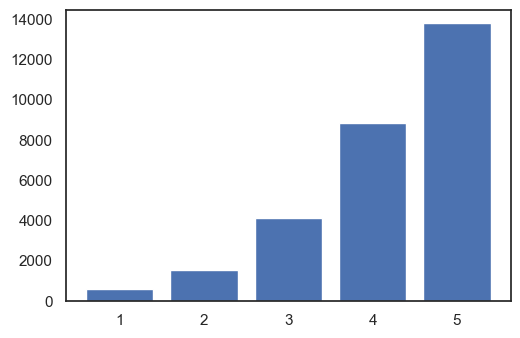

In [30]:
average_rank = df["overall"].mean()

fig = plt.figure(figsize=(10,10))

# mean_rating_of_user = df.groupby('reviewerID').apply(lambda x: x['overall'].mean())
ax = fig.add_subplot(322)
ax.bar(rating_of_user['Score'],rating_of_user['counts'])

plt.tight_layout()
plt.show()


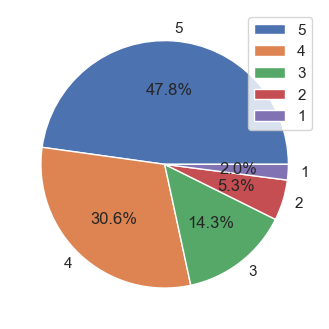

In [31]:
fig = plt.figure(figsize=(10,10))

# mean_rating_of_user = df.groupby('reviewerID').apply(lambda x: x['overall'].mean())
ax = fig.add_subplot(322)
mylabels = ["5", "4", "3", "2","1"]
ax.pie(rating_of_user['counts'], labels =mylabels,autopct='%1.1f%%')
#ax.set_xlabel(' rating given by  users', fontsize=15)
plt.tight_layout()
plt.legend()
plt.show()


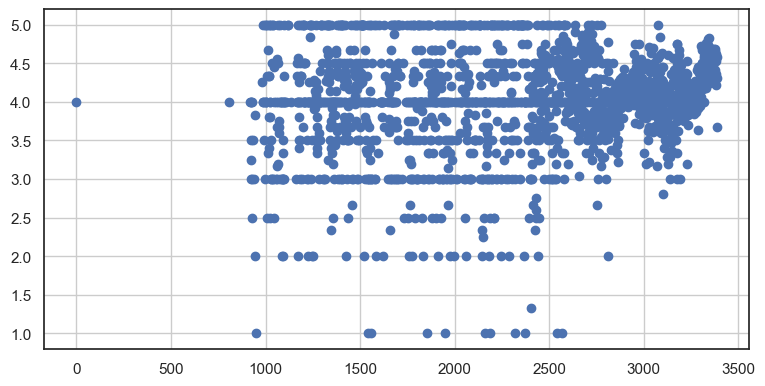

In [32]:
mean_rating_of_day = df.groupby('ReviewDay').apply(lambda x: x['overall'].mean())
mean_rating_of_day = mean_rating_of_day.reset_index(name='mean_rating')
mean_rating_of_day
x = mean_rating_of_day["ReviewDay"]
y = mean_rating_of_day["mean_rating"]
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(322)
ax.scatter(x, y)
# ax.set_xlabel('mean rating given by each day', fontsize=15)
plt.yticks(np.arange(1.0, 5.3,0.5 ))
plt.grid()
plt.show()

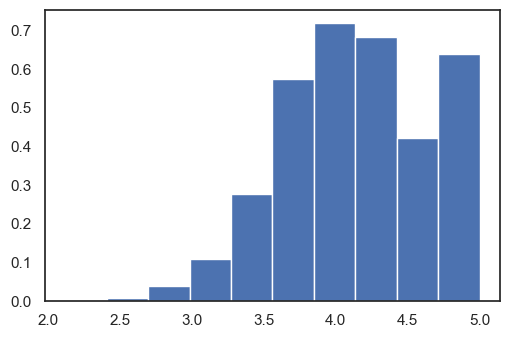

In [33]:
average_rank = df["overall"].mean()

fig = plt.figure(figsize=(10,10))

mean_rating_of_user = df.groupby('reviewerID').apply(lambda x: x['overall'].mean())
ax = fig.add_subplot(322)
ax.hist(mean_rating_of_user,density=True)
# ax.set_xlabel('mean rating given by each user', fontsize=15)

plt.tight_layout()
plt.show()

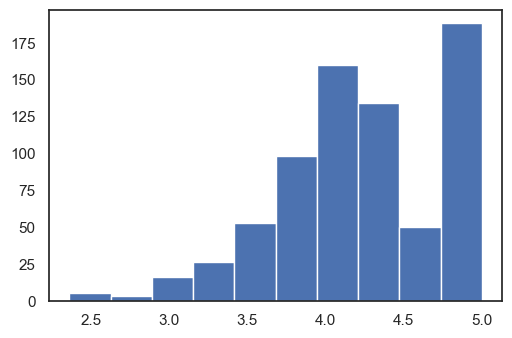

In [34]:

average_rank = df["overall"].mean()
fig = plt.figure(figsize=(10,10))

# mean ratings from each user
mean_rating_of_item = df.groupby('product').apply(lambda x: x['overall'].mean())
ax = fig.add_subplot(322)
ax.hist(mean_rating_of_item
                           
                           )
# ax.set_xlabel('mean rating by each product', fontsize=15)

plt.tight_layout()
plt.show()

Trung bình có 

In [35]:
def train_by_df(from_model, train_df, dev_df, test_df, num_user, num_item, debug = True, implicit_df = None):
    print (80 * "=")
    print ("INITIALIZING")
    print( 80 * "=")
    config = from_model.Config()
    config.n_items = num_item 
    config.n_users = num_user
    config.maxday_cat_code = max(train_df["TDayCat"].values)
    
    if not os.path.exists('data\\weights\\'):
        os.makedirs('.\\data\\weights\\')

    with tf.Graph().as_default():
        print ("Building model...",)
        start = time.time()
        model = from_model.RecommandationModel(config) 
        

        init = v1.global_variables_initializer()

        saver = None if debug else v1.train.Saver()

        with v1.Session() as session:
            #recommand.session = session
            session.run(init)

            print( 80 * "=")
            print( "TRAINING")
            print( 80 * "=")
            model.fit(session, saver, train_df, dev_df) #, implicit_df)
            print("Done!")
            print ("took {:.2f} seconds\n".format(time.time() - start))
            
            if not debug:
                print (80 * "=")
                print ("TESTING")
                print( 80 * "=")
                print ("Restoring the best model weights found on the dev set")
                saver.restore(session, model.config.weight_filename)
                #print ("Final evaluation on test set",)
                mean_rank = train_df["overall"].mean() #global rank mean
        
                mean_u_day = getMeanDaybyUser(train_df)
                test_loss = model.run_epoch(session, train_df, mean_rank, mean_u_day, test_df) 
                
                print ("- test l2 loss: {:.5f}", test_loss)

                print ("Done!")
                return test_loss

In [58]:
def train_by_df_timeVCDplus(from_model, train_df, dev_df, test_df, num_user, num_item, debug = False, implicit_df = None):
    """ Hàm main đùng dể train data theo công thức TIMESVD++
        Args:
            from_model: model mà được code để train và fit tập data
            train_df: tập train 
            dev_df: tập develop
            test_df: tập test
            num_user: số người dùng
            num_item: số sản phẩm
            implicit_df:  lịch sử các item đã được đánh giá bởi các user
        Returns:
            test_loss: giá trị MSE của tập test sau khi thay bằng bộ trọng số tốt nhất
    """
    print (80 * "=")
    print ("INITIALIZING")
    print( 80 * "=")
    config = from_model.Config()  # lấy config sẵn từ model
    config.n_items = num_item     # gán giá trị config.n_items =  số sản phẩm
    config.n_users = num_user
    config.maxday_cat_code = max(train_df["TDayCat"].values)
    
    if not os.path.exists('data\\weights\\'): # kiểm tra xem có file "weights" có trong thư mực "data" hay chưa? Nếu chưa thì tạo
        os.makedirs('.\\data\\weights\\')

    with tf.Graph().as_default():
        print ("Building model...",)
        start = time.time()
        model = from_model.RecommandationModel(config)  # chạy RecommandationModel class trong model 
        

        init = v1.global_variables_initializer() 

        saver = None if debug else v1.train.Saver()

        with v1.Session() as session:
            #recommand.session = session
            session.run(init)

            print( 80 * "=")
            print( "TRAINING")
            print( 80 * "=")
            model.fit(session, saver, train_df, dev_df, implicit_df)  # fit mô hình với tập train và tìm tập trọng số tốt nhất bằng cách đánh giá mô hình trên tập dev
            print("Done!")
            print ("took {:.2f} seconds\n".format(time.time() - start))
            
            if not debug:
                print (80 * "=")
                print ("TESTING")
                print( 80 * "=")
                print ("Restoring the best model weights found on the dev set")
                saver.restore(session, model.config.weight_filename)  # lấy tập trọng số tốt nhất đã lưu mà dùng nó để đánh giá trên tập test
                print ("Final evaluation on test set",)
                mean_rank = train_df["overall"].mean() # tính trung bình điểm xếp hạng
        
                mean_u_day = getMeanDaybyUser(train_df) # lấy số ngày trung bình đánh giá của users
                test_loss = model.run_epoch(session, train_df, mean_rank, mean_u_day, test_df, implicit_df)  # tìm giá trị loss bằng tập trọng số tốt nhất trên tập test 
                
                print ("- test l2 loss: {:.5f}", test_loss)

                print ("Done!")
                presisionk = model.calculate_precision_at_k(session,train_df, test_df,mean_rank, mean_u_day, implicit_df,10)
                print(presisionk)
                return test_loss

In [52]:
loss_dict={} # tạo từ điển để lưu giữ các trường hợp temporal dynamics


This is the whole matrix factorization model(timeVCD++) for recommender system:
\begin{align}
\hat{r}_{ui} = \mu + b_i(t_{ui}) + b_u(t_{ui}) + q_i^T\left(p_u(t_{ui}) + |R(u)|^{-\frac{1}{2}}\sum_{j \in R(u)}y_j\right) \\
p_{uk}(t) = p_{uk} + \alpha_{uk}{\cdot}dev_u(t) + p_{uk,t}  \\
b_i(t_{ui}) = b_i + b_{i,Bin(t)}\\
b_u(t_{ui}) = b_u + \alpha_{u}{\cdot}dev_u(t) + b_{u,t}
\end{align}

\begin{align}
Loss = \sum_{(u,i) \in K}(r_{ui} - \hat{r}{ui})^2 + \lambda(\sum{u}||p_u||^2 + \sum_{i}||q_i||^2 + \sum_{i}||b_i||^2 + \sum_{u}||b_u||^2 + \sum_{u,k}||\alpha_{uk}||^2) \\
\lambda \left(\sum_{i}^{K}||q_i||^2 + \sum_{u}^{M}||p_u||^2 + \sum_{i}^{N}||b_i||^2 + \sum_{u}^{M}||b_u||^2 + \sum_{u,k}^{M,K}||\alpha_{uk}||^2 + \sum_{u,t}^{M,T}||b_{u,t}||^2 + \sum_{i,B}^{N,B}||b_{i,B}||^2\right)\\
loss = \frac{1}{2} \left(|\hat{r}{ui} - r{ui}|^2_2\right) + \frac{\lambda_4}{2} \left(|b_u|^2_2 + |b_i|^2_2 + |q_i|^2_2 + |p_u|^2_2\right) 
+ \frac{\lambda_5}{2} \left(|b_{i,Bin(t)}|^2_2\right) + \frac{\lambda_6}{2} \left(|b_{u,t}|^2_2\right) + \frac{\lambda_7}{2} \left(|b_t|^2_2\right) + \frac{\lambda_8}{2} \left(|w_{cu}|^2_2 + |b_{cu}|^2_2\right) + \frac{\lambda_9}{2} \left(|w_{puk,t}|^2_2 + |\alpha_{uk}|^2_2\right)
\end{align}

In [59]:
loss_dict["TimeSVD++"] = train_by_df_timeVCDplus(tall, train_df, dev_df, test_df, num_user, num_item, debug = False, implicit_df = implicit_train_df ) # TrainingSparseUiVectorT_Implicit

INITIALIZING
Building model...
TRAINING
Epoch 1 out of 30
Evaluating on dev set
current DEV loss =  0.908372606490365
new best dev loss!: 0.908372606490365
New best dev UAS! data\weights\recommanding_with_IU_time_drifting.weight


FailedPreconditionError: data\weights is not a directory

In [17]:
loss_dict["Mf_bias"] = train_by_df(tdv, train_df, dev_df, test_df, num_user, num_item, debug = False)

INITIALIZING
Building model...
TRAINING
Epoch 1 out of 30
Evaluating on dev set
current DEV loss =  0.958766159149938
new best dev loss!: 0.958766159149938
New best dev UAS! data\weights\recommanding_with_user_time_drifting.weight


FailedPreconditionError: data\weights is not a directory

In [47]:
loss_dict["VTDay"] = train_by_df(tdiuvtday, train_df, dev_df, test_df, num_user, num_item, debug = False) #TrainingSparseUIVectorTDay

INITIALIZING
Building model...
TRAINING
Epoch 1 out of 30
current DEV loss =  0.9375539590476625
new best dev loss!: 0.9375539590476625
New best dev UAS! data\weights\recommanding_with_IU_time_drifting.weight


FailedPreconditionError: data\weights is not a directory

In [18]:
loss_dict["IUDay"] = train_by_df(tdiutday, train_df, dev_df, test_df, num_user, num_item, debug = False) 

INITIALIZING
Building model...
Tensor("Add_6:0", shape=(None,), dtype=float32, device=/device:CPU:0)
TRAINING
Epoch 1 out of 30
Evaluating on dev set
current DEV loss =  0.9005713473268656
new best dev loss!: 0.9005713473268656
New best dev UAS! data\weights\recommanding_with_IU_time_drifting.weight
INFO:tensorflow:data\weights\recommanding_with_IU_time_drifting.weight.data-00000-of-00001
INFO:tensorflow:800
INFO:tensorflow:data\weights\recommanding_with_IU_time_drifting.weight.index
INFO:tensorflow:800
INFO:tensorflow:data\weights\recommanding_with_IU_time_drifting.weight.meta
INFO:tensorflow:900

Epoch 2 out of 30
Evaluating on dev set
current DEV loss =  0.8407538861027266
new best dev loss!: 0.8407538861027266
New best dev UAS! data\weights\recommanding_with_IU_time_drifting.weight
INFO:tensorflow:data\weights\recommanding_with_IU_time_drifting.weight.data-00000-of-00001
INFO:tensorflow:800
INFO:tensorflow:data\weights\recommanding_with_IU_time_drifting.weight.index
INFO:tensorflow

In [29]:
loss_dict["UserDay"] = train_by_df(tdutday, train_df, dev_df, test_df, num_user, num_item, debug = False)

INITIALIZING
Building model...
TRAINING
Epoch 1 out of 30
Evaluating on dev set
current DEV loss =  0.9742395419966089
new best dev loss!: 0.9742395419966089
New best dev UAS! data\weights\recommanding_with_user_day_drifting.weight
INFO:tensorflow:data\weights\recommanding_with_user_day_drifting.weight.data-00000-of-00001
INFO:tensorflow:800
INFO:tensorflow:data\weights\recommanding_with_user_day_drifting.weight.index
INFO:tensorflow:800
INFO:tensorflow:data\weights\recommanding_with_user_day_drifting.weight.meta
INFO:tensorflow:900

Epoch 2 out of 30
Evaluating on dev set
current DEV loss =  0.9543292599801652
new best dev loss!: 0.9543292599801652
New best dev UAS! data\weights\recommanding_with_user_day_drifting.weight
INFO:tensorflow:data\weights\recommanding_with_user_day_drifting.weight.data-00000-of-00001
INFO:tensorflow:800
INFO:tensorflow:data\weights\recommanding_with_user_day_drifting.weight.index
INFO:tensorflow:800
INFO:tensorflow:data\weights\recommanding_with_user_day_dr

In [30]:
loss_dict["UserTime"] = train_by_df(tdut, train_df, dev_df, test_df, num_user, num_item, debug = False)

INITIALIZING
Building model...
Instructions for updating:
Use `tf.cast` instead.
TRAINING
Epoch 1 out of 30
Evaluating on dev set
current DEV loss =  0.8724814653200788
new best dev loss!: 0.8724814653200788
New best dev UAS! data\weights\recommanding_with_user_time_drifting.weight
INFO:tensorflow:data\weights\recommanding_with_user_time_drifting.weight.data-00000-of-00001
INFO:tensorflow:700
INFO:tensorflow:data\weights\recommanding_with_user_time_drifting.weight.index
INFO:tensorflow:700
INFO:tensorflow:data\weights\recommanding_with_user_time_drifting.weight.meta
INFO:tensorflow:800

Epoch 2 out of 30
Evaluating on dev set
current DEV loss =  0.8139537460169732
new best dev loss!: 0.8139537460169732
New best dev UAS! data\weights\recommanding_with_user_time_drifting.weight
INFO:tensorflow:data\weights\recommanding_with_user_time_drifting.weight.data-00000-of-00001
INFO:tensorflow:700
INFO:tensorflow:data\weights\recommanding_with_user_time_drifting.weight.index
INFO:tensorflow:700
I

In [31]:
loss_dict["ItemTime"] = train_by_df(tdit, train_df, dev_df, test_df, num_user, num_item, debug = False)

INITIALIZING
Building model...
TRAINING
Epoch 1 out of 30
Evaluating on dev set
current DEV loss =  0.8709362729118717
new best dev loss!: 0.8709362729118717
New best dev UAS! data\weights\recommanding_with_user_time_drifting.weight
INFO:tensorflow:data\weights\recommanding_with_user_time_drifting.weight.data-00000-of-00001
INFO:tensorflow:700
INFO:tensorflow:data\weights\recommanding_with_user_time_drifting.weight.index
INFO:tensorflow:700
INFO:tensorflow:data\weights\recommanding_with_user_time_drifting.weight.meta
INFO:tensorflow:800

Epoch 2 out of 30
Evaluating on dev set
current DEV loss =  0.8118558040452809
new best dev loss!: 0.8118558040452809
New best dev UAS! data\weights\recommanding_with_user_time_drifting.weight
INFO:tensorflow:data\weights\recommanding_with_user_time_drifting.weight.data-00000-of-00001
INFO:tensorflow:700
INFO:tensorflow:data\weights\recommanding_with_user_time_drifting.weight.index
INFO:tensorflow:700
INFO:tensorflow:data\weights\recommanding_with_user

(0.65, 0.8168425198218869)

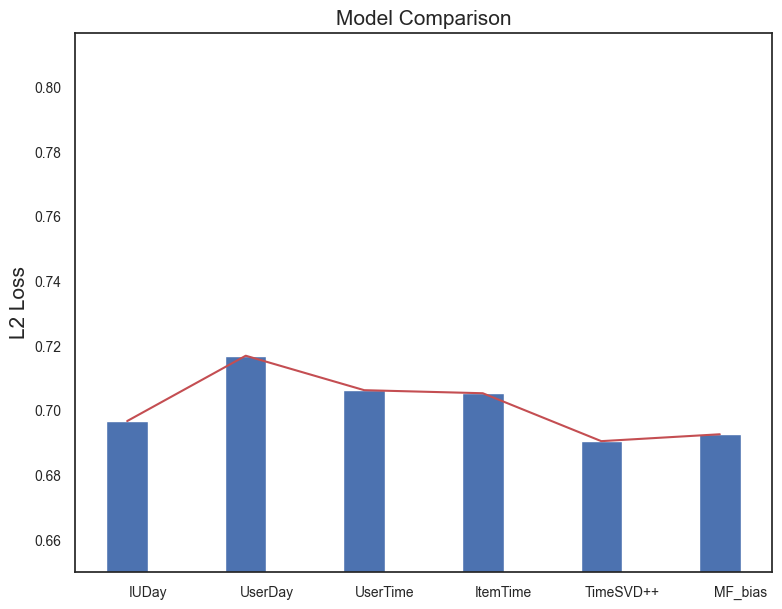

In [56]:
N = len(loss_dict.values())
x = list(loss_dict.values()) 

ind = np.arange(N)  
width = 0.35       # the width of the bars

fig, ax = plt.subplots(figsize=(9, 7))
g1 = ax.bar(ind, x, width, color='b')
g2 = ax.plot(x, 'r')

# add some text for labels, title and axes ticks
ax.set_ylabel('L2 Loss', fontsize=15)
ax.set_title('Model Comparison', fontsize=15)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(list(loss_dict.keys())) 
ax.tick_params(labelsize=10)
ax.set_ylim([0.65, max(x) + 0.1])


In [31]:
print(loss_dict)

{'Base': 0.9402628908705278, 'TALL': 0.6967532979361492, 'VTDay': 0.7019107073634686, 'IUDay': 0.7095794233245478, 'UserDay': 0.7280815032559352, 'UserTime': 0.7153736198611326, 'ItemTime': 0.7109673097085407, 'Vector': 0.7013677447121663, 'Biasonly': 0.7024042325245001}
